In [304]:
# import the libraries

import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50

In [305]:
# initialize the constants: 
# Initial Learning Rate
# Epochs
# Batch Size
# Length 
# Width 

INITIAL_LEARINGRATE = .001
EPOCHS = 30
BATCH_SIZE = 32
LENGTH = 224
WIDTH = 224

# Exploratory Data Analysis

In [306]:
# images without covid
wOut_Covid = list(pathlib.Path("../DATA").glob('0/*'))

# images with covid
w_Covid = list(pathlib.Path("../DATA").glob('1/*'))

There are 1301 images without Covid
There are 1790 images without Covid


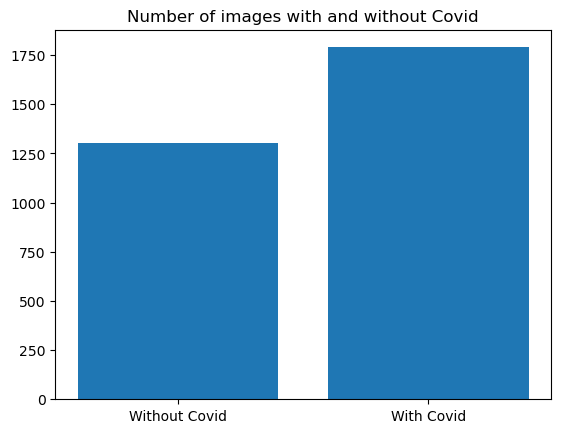

In [307]:
# number of images with and without covid

print('There are', len(wOut_Covid), 'images without Covid')
print('There are', len(w_Covid), 'images without Covid')

plt.bar(['Without Covid', 'With Covid'], [len(wOut_Covid), len(w_Covid)], align = 'center')
plt.title('Number of images with and without Covid')
plt.show()

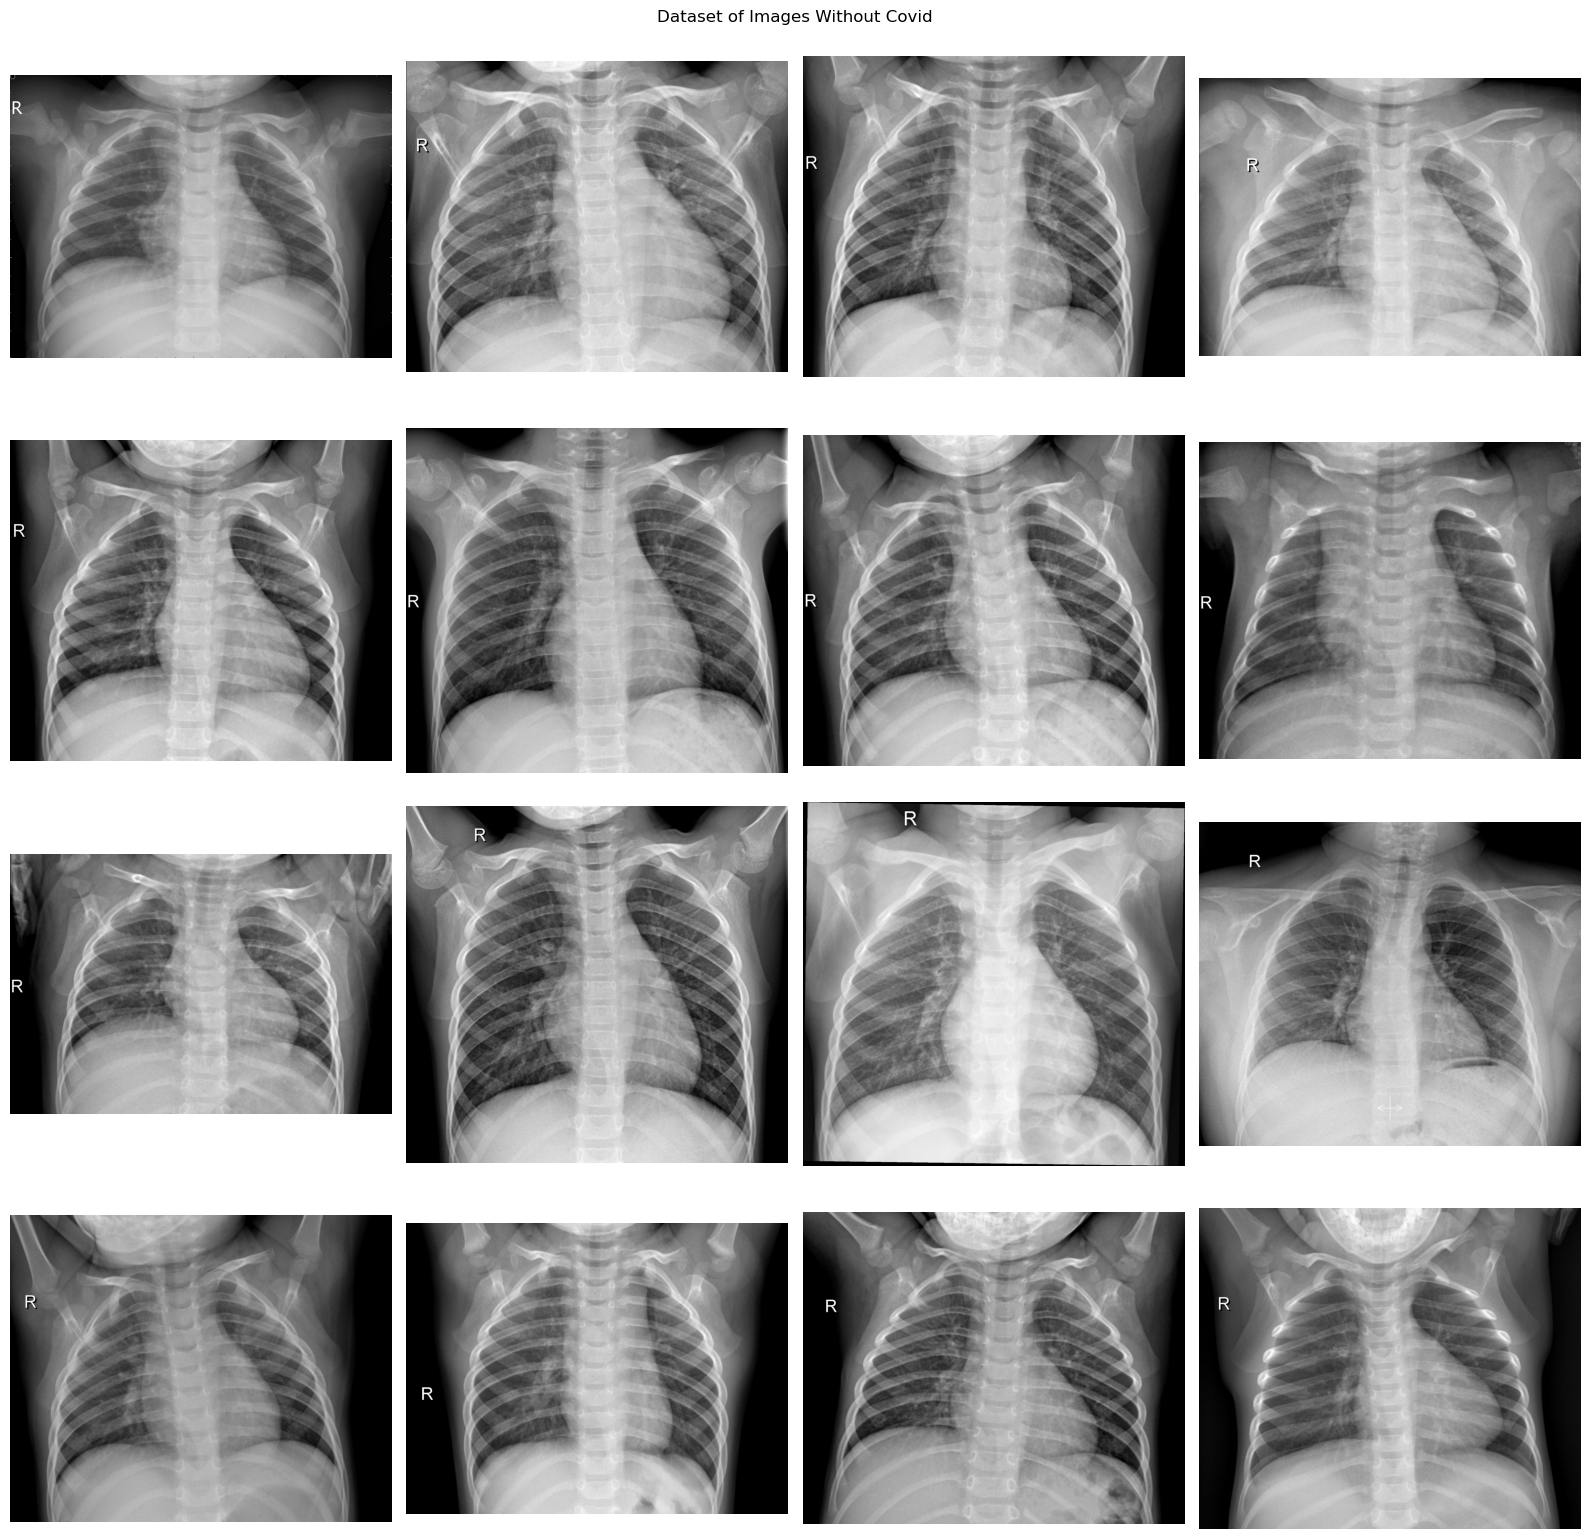

In [308]:
# grab the image path for the images without covid
image_dir = "../DATA/0/"

# create a 4x4 subplot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.ravel() # flatten the axes array

# get a list of all image files in the directory
image_files = [filename for filename in os.listdir(image_dir)]

# randomly select 16 images from the list
selected_files = random.sample(image_files, k=16)

# loop through the selected files
for i, filename in enumerate(selected_files):
    # load the image using matplotlib
    img = plt.imread(os.path.join(image_dir, filename))

    # display the image in the appropriate subplot
    axs[i].imshow(img.astype("uint8"))
    axs[i].axis('off')
     
# show the plot
plt.suptitle('Dataset of Images Without Covid')
plt.tight_layout()
plt.show() 

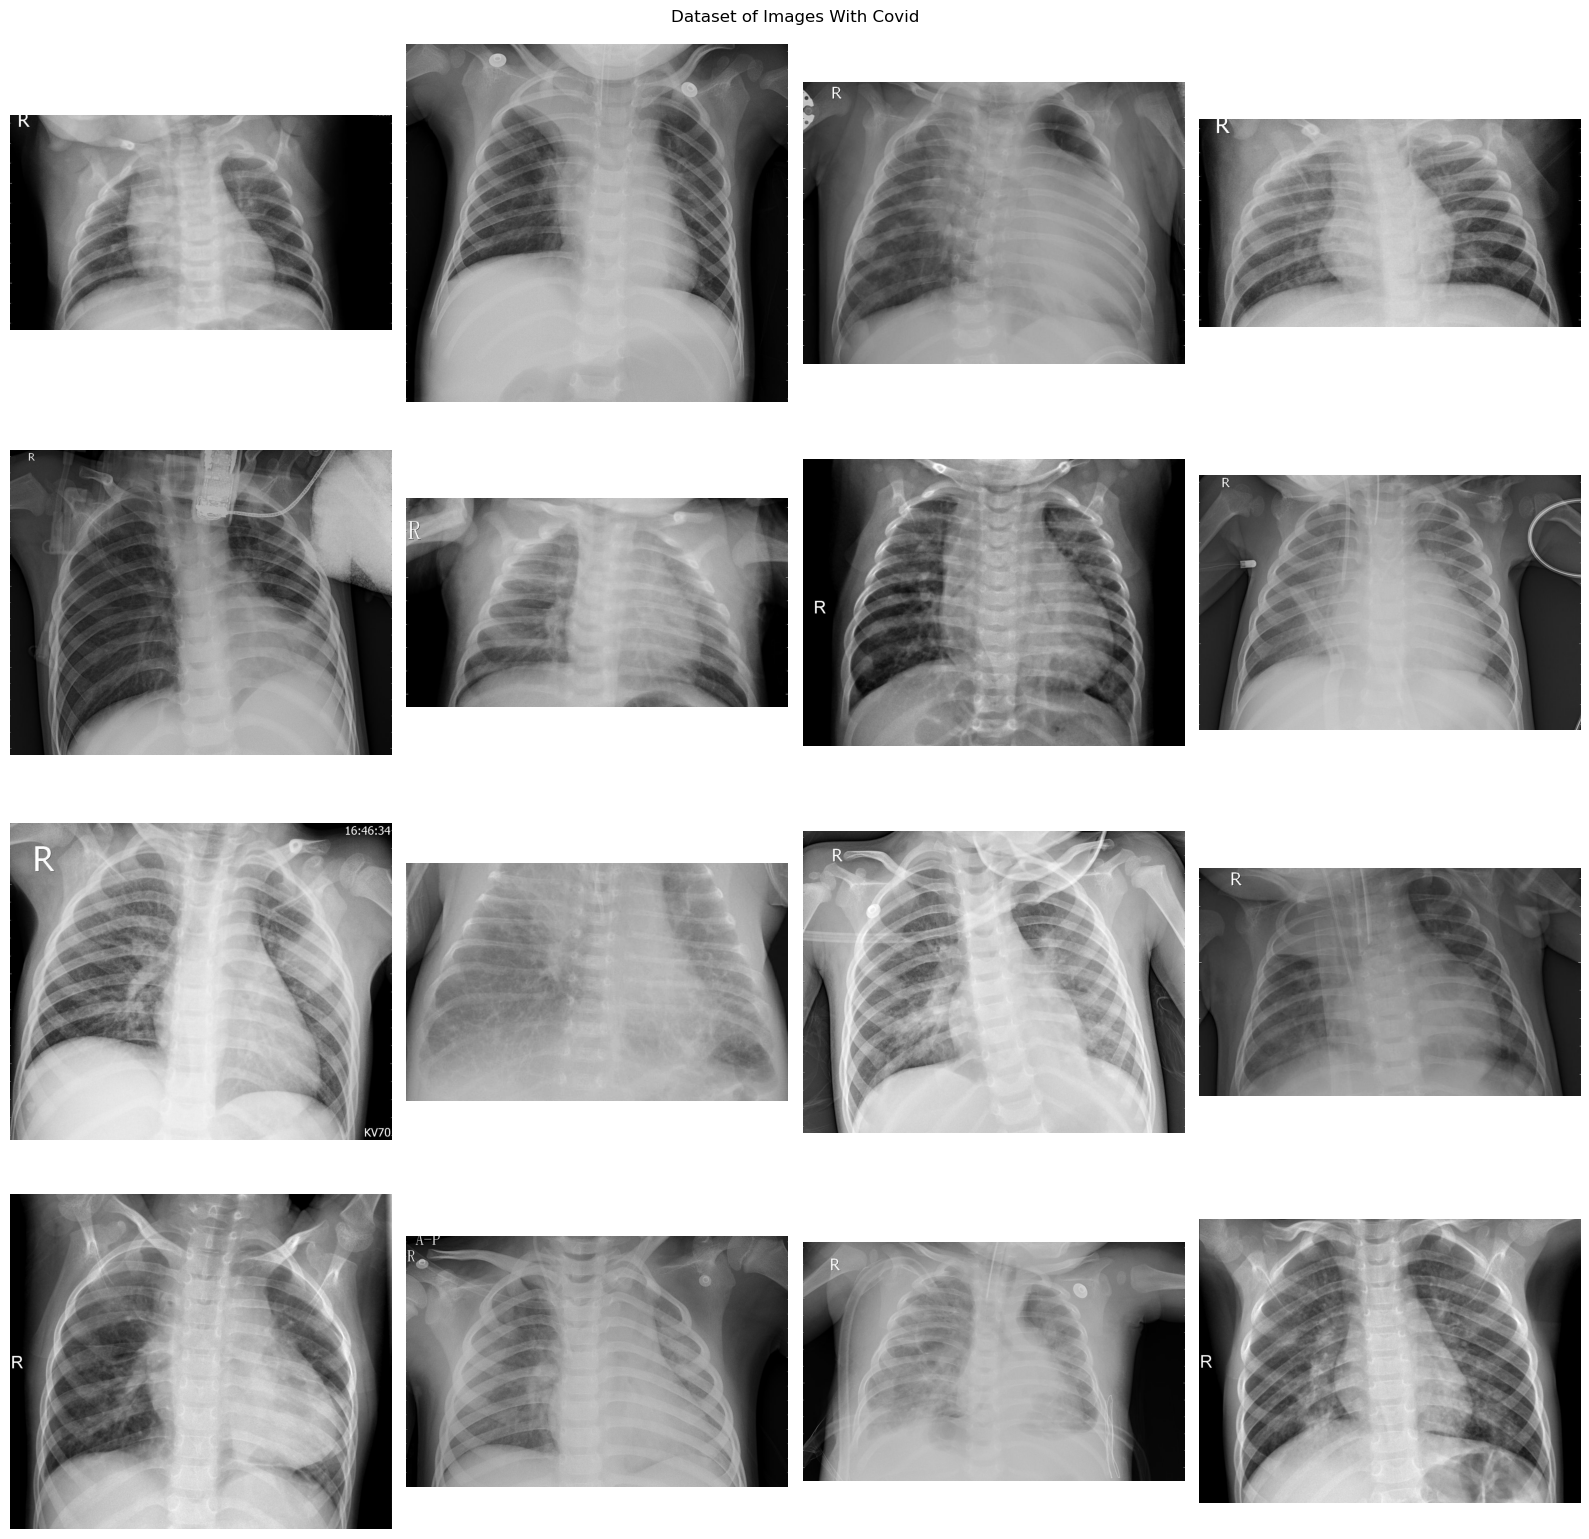

In [309]:
# grab the image path for the images with covid
image_dir = "../DATA/1/"

# create a 4x4 subplot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.ravel() # flatten the axes array

# get a list of all image files in the directory
image_files = [filename for filename in os.listdir(image_dir)]

# randomly select 16 images from the list
selected_files = random.sample(image_files, k=16)

# loop through the selected files
for i, filename in enumerate(selected_files):
    # load the image using matplotlib
    img = plt.imread(os.path.join(image_dir, filename))

    # display the image in the appropriate subplot
    axs[i].imshow(img.astype("uint8"))
    axs[i].axis('off')
     
# show the plot
plt.suptitle('Dataset of Images With Covid')
plt.tight_layout()
plt.show() 

# Preprocessing the Data

In [310]:
# take the images and put them into lists
image_path = list(paths.list_images(r"../DATA/"))

In [311]:
# create empty list for the data and the labels
data = list()
labels = list()

In [312]:
# now we want to loop over all the images in the files and then rescale them to a 224x224 aspect ratio. This will be done via the CV library
for x in image_path:
    # getting the classlabel
    label = x.split(os.path.sep)[-2]

    # now, we load the image, change the color to RGB and then resize it
    image = cv2.imread(x)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(LENGTH,WIDTH))

    # update our label and data list
    labels.append(label)
    data.append(image)


In [313]:
# convert the data and labels to Numpy Arrays while scaling the pixel intensity
data = np.array(data) / 255.0 # 255 RGB colors
data.reshape(-1,1)
labels = np.array(labels)

In [314]:
# one-hot encoding the models
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [315]:
# creating our train and test data. Using standard practice, 80% of the dataset will be used for training 
# while the 20% will be used for testing
trainX, testX, trainY, testY = train_test_split(data,labels,test_size=.2, stratify=labels,random_state=42)

In [316]:
# initialize the training data augmentation object
train_augment = ImageDataGenerator(
    rotation_range = 15,
    fill_mode = 'nearest'
)

train_augment_bis = ImageDataGenerator(
    rotation_range = 15,
    vertical_flip = True, 
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Models

VGG16 Model

In [317]:
# load the base model
base_model = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(LENGTH,WIDTH,3)))

In [318]:
# create the head of the model that is going to be on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(64, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [319]:
# now we will create our model; this model will be the one that is used to do the trainings
model = Model(inputs=base_model.input, outputs=head_model)

In [320]:
# freeze the layers of the base model so its not updated during the first training process
for y in base_model.layers:
    y.trainable = False

Compiling the Model

In [321]:
# using the ADAM optimizer to optimize
optimizer = Adam(learning_rate=INITIAL_LEARINGRATE, weight_decay = INITIAL_LEARINGRATE/EPOCHS)

In [322]:
# compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Training the Network

In [323]:
# train the head of the network
head = model.fit(
    train_augment.flow(trainX,trainY,batch_size=BATCH_SIZE),
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Making Predictions

In [324]:
# predicting using the trained model
predict = model.predict(testX,batch_size=BATCH_SIZE)

In [325]:
# for each image, find the index of the label corresponding with the largest predicted probability
predict = np.argmax(predict,axis=1)

In [326]:
# now represent the prediction in a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predict,target_names=lb.classes_))

Confusion Matrix For Statistical Evaluation

In [327]:
# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY.argmax(axis=1),predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])

In [328]:
# display the output
print(confusionMatrix)
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))


Plot for Visual Representation

In [329]:
# graph for visual representation
# plt.plot(np.arange(0, EPOCHS), head.history["loss"], label="train_loss")
# plt.plot(np.arange(0, EPOCHS), head.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, EPOCHS), head.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, EPOCHS), head.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on COVID-19 Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="center right")
# plt.show()

ResNet50 Model

In [330]:
# load the base model 
base_model = ResNet50(weights='imagenet', include_top=False,input_tensor=Input(shape=(LENGTH,WIDTH,3)))

In [331]:
# create the head of the model that is going to be on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(64, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [332]:
# now we will create our model; this model will be the one that is used to do the trainings
model = Model(inputs=base_model.input, outputs=head_model)

In [333]:
# freeze the layers of the base model so its not updated during the first training process
for y in base_model.layers:
    y.trainable = False

Compiling the Model

In [334]:
# using the ADAM optimizer to optimize
optimizer = Adam(learning_rate=INITIAL_LEARINGRATE, weight_decay = INITIAL_LEARINGRATE/EPOCHS)

In [335]:
# compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Training the Network

In [336]:
# train the head of the network
head = model.fit(
    train_augment_bis.flow(trainX,trainY,batch_size=BATCH_SIZE),
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/30


2023-04-15 18:12:53.963078: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - 197s 3s/step - loss: 0.6841 - accuracy: 0.5705 - val_loss: 0.6591 - val_accuracy: 0.5913
Epoch 2/30
77/77 [==============================] - 192s 2s/step - loss: 0.6580 - accuracy: 0.6102 - val_loss: 0.6449 - val_accuracy: 0.5784
Epoch 3/30
77/77 [==============================] - 197s 3s/step - loss: 0.6461 - accuracy: 0.6275 - val_loss: 0.6187 - val_accuracy: 0.5848
Epoch 4/30
77/77 [==============================] - 208s 3s/step - loss: 0.6202 - accuracy: 0.6422 - val_loss: 0.5834 - val_accuracy: 0.7270
Epoch 5/30
77/77 [==============================] - 206s 3s/step - loss: 0.5876 - accuracy: 0.6721 - val_loss: 0.5470 - val_accuracy: 0.7124
Epoch 6/30
77/77 [==============================] - 208s 3s/step - loss: 0.5660 - accuracy: 0.6848 - val_loss: 0.5200 - val_accuracy: 0.7771
Epoch 7/30
77/77 [==============================] - 214s 3s/step - loss: 0.5524 - accuracy: 0.7020 - val_loss: 0.5146 - val_accuracy: 0.7609
Epoch 8/30
77/77 [======

Making Predictions

In [337]:
# predicting using the trained model
predict = model.predict(testX,batch_size=BATCH_SIZE)

20/20 [==============================] - 35s 2s/step


In [338]:
# for each image, find the index of the label corresponding with the largest predicted probability
predict = np.argmax(predict,axis=1)

In [339]:
# now represent the prediction in a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       261
           1       0.92      0.80      0.85       358

    accuracy                           0.84       619
   macro avg       0.84      0.85      0.84       619
weighted avg       0.86      0.84      0.84       619



Confusion Marix for Statistical Evaluation

In [340]:
# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY.argmax(axis=1),predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])

In [341]:
# display the output
print(confusionMatrix)
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))

[[237  24]
 [ 73 285]]
Accuracy:     0.843
Sensitivity:  0.908
Specificity:  0.796


Plot for Visual Representation

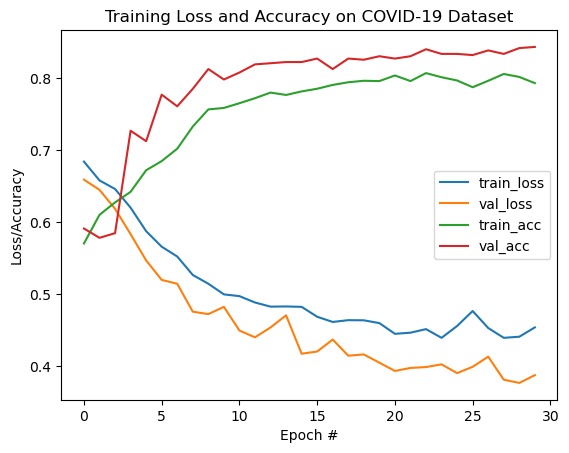

In [342]:
# graph for visual representation
plt.plot(np.arange(0, EPOCHS), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()